# [House Prices Predict](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

### 第一步：探索式資料分析 EDA(exploratory data analysis)

* 釐清問題: 屬於 $Regression$ 還是 $classification$ 問題
* 觀察特徵
* 對資料先進行初步整理
* 建立思考方向: 
    * 從預測值下手: 當房價變化時，哪些特徵有明顯的變化?  (正相關, 負相關, 無相關, 離群值)
    * 從特徵下手: 當某一個特徵變化時，哪些特徵亦有明顯的變化?  (ECDF(empirical distribution function))
* 清楚方向之後，針對特徵進行更進一步的篩選或是處理(例如: 排除無助於預測的特徵、離群值, 轉換類別數據, 特徵轉換)

### 第二步：建立預測模型
    
###  第三部：模型評估

* 針對迴歸問題，經常使用的評價指標有
    * 平均方差 $MSE$ `(mean_squared_error)`
    * 平均絕對誤差 $MAE$ `(mean_absolute_error)`
    * 判定係數 $R^2$ `(R-squared)`

### 導入模塊

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from scipy.stats import skew
from sklearn.preprocessing import Imputer

from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

### 讀取資料

In [2]:
# 房價資料包含了79個特徵，訓練資料數量為1460筆，測試資料則為1459筆
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [3]:
print(f'資料個數 : {len(train.index)}')
print(f'資料特徵 : {len(train.columns[1:-1])}')  # 扣除 ID 和 target
print(f'特徵名稱 : \n{list(train.columns[1:-1])}')

資料個數 : 1460
資料特徵 : 79
特徵名稱 : 
['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorc

In [4]:
# 將訓練資料與測試資料合併，原因是為了同時觀察全部資料的缺失值、欄位評級
alldata = pd.concat((train.loc[:, 'MSSubClass':'SaleCondition'], test.loc[:, 'MSSubClass':'SaleCondition']))
alldata = alldata.reset_index(drop=True)
print(f'總資料個數 : {len(alldata.index)}')
print(f'總資料特徵 : {len(alldata.columns)}')

總資料個數 : 2919
總資料特徵 : 79


### 統計資料缺失值
* 資料探索，檢查了所有資料的缺失值 `NaN`

In [5]:
missing_num = np.sum(alldata.isnull())
missing_num = missing_num[missing_num > 0].sort_values(ascending=False)
for feature, val in zip(missing_num.index, missing_num.values):
    if (alldata[feature].dtype == 'object'):
        print(f'{feature:<15s} 缺失值的個數(訓練集 + 測試集) : {val:<4d}')


PoolQC          缺失值的個數(訓練集 + 測試集) : 2909
MiscFeature     缺失值的個數(訓練集 + 測試集) : 2814
Alley           缺失值的個數(訓練集 + 測試集) : 2721
Fence           缺失值的個數(訓練集 + 測試集) : 2348
FireplaceQu     缺失值的個數(訓練集 + 測試集) : 1420
GarageFinish    缺失值的個數(訓練集 + 測試集) : 159 
GarageQual      缺失值的個數(訓練集 + 測試集) : 159 
GarageCond      缺失值的個數(訓練集 + 測試集) : 159 
GarageType      缺失值的個數(訓練集 + 測試集) : 157 
BsmtExposure    缺失值的個數(訓練集 + 測試集) : 82  
BsmtCond        缺失值的個數(訓練集 + 測試集) : 82  
BsmtQual        缺失值的個數(訓練集 + 測試集) : 81  
BsmtFinType2    缺失值的個數(訓練集 + 測試集) : 80  
BsmtFinType1    缺失值的個數(訓練集 + 測試集) : 79  
MasVnrType      缺失值的個數(訓練集 + 測試集) : 24  
MSZoning        缺失值的個數(訓練集 + 測試集) : 4   
Utilities       缺失值的個數(訓練集 + 測試集) : 2   
Functional      缺失值的個數(訓練集 + 測試集) : 2   
Exterior2nd     缺失值的個數(訓練集 + 測試集) : 1   
Exterior1st     缺失值的個數(訓練集 + 測試集) : 1   
SaleType        缺失值的個數(訓練集 + 測試集) : 1   
Electrical      缺失值的個數(訓練集 + 測試集) : 1   
KitchenQual     缺失值的個數(訓練集 + 測試集) : 1   


### 資料清洗 (Data Cleaning)
* 填補缺失值 `NaN`

In [6]:
# 填補缺失值
def fill_nan(data):
    data['LotFrontage'] = data['LotFrontage'].fillna(0)
    data['BsmtFinSF1'] = data['BsmtFinSF1'].fillna(0)
    data['BsmtFinSF2'] = data['BsmtFinSF2'].fillna(0)
    data['Alley'] = data['Alley'].fillna('None')
    data['MasVnrType'] = data['MasVnrType'].fillna('None')
    data['MasVnrArea'] = data['MasVnrArea'].fillna(0)
    data['BsmtQual'] = data['BsmtQual'].fillna('None')
    data['BsmtCond'] = data['BsmtCond'].fillna('None')
    data['BsmtExposure'] = data['BsmtExposure'].fillna('None')
    data['BsmtFinType1'] = data['BsmtFinType1'].fillna('None')
    data['BsmtFinType2'] = data['BsmtFinType2'].fillna('None')
    data['Electrical'] = data['Electrical'].fillna('SBrkr')
    data['FireplaceQu'] = data['FireplaceQu'].fillna('None')
    data['GarageType'] = data['GarageType'].fillna('Attchd')
    data = data.drop('GarageYrBlt', axis=1)
    data['GarageFinish'] = data['GarageFinish'].fillna('Unf')
    data['GarageQual'] = data['GarageQual'].fillna('TA')
    data['GarageCond'] = data['GarageCond'].fillna('TA')
    data['PoolQC'] = data['PoolQC'].fillna('None')
    data['Fence'] = data['Fence'].fillna('None')
    data['MiscFeature'] = data['MiscFeature'].fillna('None')
    data['MSZoning'] = data['MSZoning'].fillna(data['MSZoning'].mode()[0]) # 針對數量極少的NaN，直接使用眾數來代替
    data['Utilities'] = data['Utilities'].fillna(data['Utilities'].mode()[0])
    data['Exterior1st'] = data['Exterior1st'].fillna(data['Exterior1st'].mode()[0])
    data['Exterior2nd'] = data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0])
    data['BsmtUnfSF'] = data['BsmtUnfSF'].fillna(data['BsmtUnfSF'].mode()[0])
    data['TotalBsmtSF'] = data['TotalBsmtSF'].fillna(data['TotalBsmtSF'].mode()[0])
    data['BsmtFullBath'] = data['BsmtFullBath'].fillna(data['BsmtFullBath'].mode()[0])
    data['BsmtHalfBath'] = data['BsmtHalfBath'].fillna(data['BsmtHalfBath'].mode()[0])
    data['KitchenQual'] = data['KitchenQual'].fillna(data['KitchenQual'].mode()[0])
    data['Functional'] = data['Functional'].fillna(data['Functional'].mode()[0])
    data['GarageCars'] = data['GarageCars'].fillna(data['GarageCars'].mode()[0])
    data['GarageArea'] = data['GarageArea'].fillna(data['GarageArea'].mode()[0])
    data['SaleType'] = data['SaleType'].fillna(data['SaleType'].mode()[0])

    return data

In [7]:
alldata = fill_nan(alldata)
print('處理完後NaN數量:',alldata.isnull().any().sum())

處理完後NaN數量: 0


### 特徵工程 (Feature Engineering)

In [8]:
num_object = 0
for col in alldata.columns:
    if alldata[col].dtype == 'object':
        print(f'{col:<12} 資料類別{alldata[col].dtype} {np.unique(alldata[col])}')
        print('-----------------------------------------------------------------------------------------------------')
        num_object += 1
print(f'共{num_object}比 Categorical Features')

MSZoning     資料類別object ['C (all)' 'FV' 'RH' 'RL' 'RM']
-----------------------------------------------------------------------------------------------------
Street       資料類別object ['Grvl' 'Pave']
-----------------------------------------------------------------------------------------------------
Alley        資料類別object ['Grvl' 'None' 'Pave']
-----------------------------------------------------------------------------------------------------
LotShape     資料類別object ['IR1' 'IR2' 'IR3' 'Reg']
-----------------------------------------------------------------------------------------------------
LandContour  資料類別object ['Bnk' 'HLS' 'Low' 'Lvl']
-----------------------------------------------------------------------------------------------------
Utilities    資料類別object ['AllPub' 'NoSeWa']
-----------------------------------------------------------------------------------------------------
LotConfig    資料類別object ['Corner' 'CulDSac' 'FR2' 'FR3' 'Inside']
-----------------------------------

In [9]:
num_nonobject = 0
for col in alldata.columns:
    if alldata[col].dtype != 'object':
        print(f'{col:<12} 資料類別{alldata[col].dtype}')
        num_nonobject += 1
print(f'共{num_nonobject}比 Numerical Features')

MSSubClass   資料類別int64
LotFrontage  資料類別float64
LotArea      資料類別int64
OverallQual  資料類別int64
OverallCond  資料類別int64
YearBuilt    資料類別int64
YearRemodAdd 資料類別int64
MasVnrArea   資料類別float64
BsmtFinSF1   資料類別float64
BsmtFinSF2   資料類別float64
BsmtUnfSF    資料類別float64
TotalBsmtSF  資料類別float64
1stFlrSF     資料類別int64
2ndFlrSF     資料類別int64
LowQualFinSF 資料類別int64
GrLivArea    資料類別int64
BsmtFullBath 資料類別float64
BsmtHalfBath 資料類別float64
FullBath     資料類別int64
HalfBath     資料類別int64
BedroomAbvGr 資料類別int64
KitchenAbvGr 資料類別int64
TotRmsAbvGrd 資料類別int64
Fireplaces   資料類別int64
GarageCars   資料類別float64
GarageArea   資料類別float64
WoodDeckSF   資料類別int64
OpenPorchSF  資料類別int64
EnclosedPorch 資料類別int64
3SsnPorch    資料類別int64
ScreenPorch  資料類別int64
PoolArea     資料類別int64
MiscVal      資料類別int64
MoSold       資料類別int64
YrSold       資料類別int64
共35比 Numerical Features


In [10]:
NumStr = ["MSSubClass","BsmtFullBath","BsmtHalfBath","HalfBath","BedroomAbvGr","KitchenAbvGr",
          "MoSold","YrSold","YearBuilt","YearRemodAdd","LowQualFinSF"]
for col in NumStr:
    alldata[col] = alldata[col].astype(str)

### 針對有意義的各個欄位的順序資料評級給予一個數值
* 檢查所有欄位評級，在評價上有優劣關係的欄位，使用`LabelEncoder`轉成數值型態。

In [11]:
# 將一些 numerical features 轉換成 categorical features
def map_values(data):
    data["oMSSubClass"] = data.MSSubClass.map({'180':1, 
                                        '30':2, '45':2, 
                                        '190':3, '50':3, '90':3, 
                                        '85':4, '40':4, '160':4, 
                                        '70':5, '20':5, '75':5, '80':5, '150':5,
                                        '120': 6, '60':6})
    
    data["oMSZoning"] = data.MSZoning.map({'C (all)':1, 'RH':2, 'RM':2, 'RL':3, 'FV':4})
    
    data["oNeighborhood"] = data.Neighborhood.map({'MeadowV':1,
                                               'IDOTRR':2, 'BrDale':2,
                                               'OldTown':3, 'Edwards':3, 'BrkSide':3,
                                               'Sawyer':4, 'Blueste':4, 'SWISU':4, 'NAmes':4,
                                               'NPkVill':5, 'Mitchel':5,
                                               'SawyerW':6, 'Gilbert':6, 'NWAmes':6,
                                               'Blmngtn':7, 'CollgCr':7, 'ClearCr':7, 'Crawfor':7,
                                               'Veenker':8, 'Somerst':8, 'Timber':8,
                                               'StoneBr':9,
                                               'NoRidge':10, 'NridgHt':10})
    
    data["oCondition1"] = data.Condition1.map({'Artery':1,
                                           'Feedr':2, 'RRAe':2,
                                           'Norm':3, 'RRAn':3,
                                           'PosN':4, 'RRNe':4,
                                           'PosA':5 ,'RRNn':5})
    
    data["oBldgType"] = alldata.BldgType.map({'2fmCon':1, 'Duplex':1, 'Twnhs':1, '1Fam':2, 'TwnhsE':2})
    
    data["oHouseStyle"] = data.HouseStyle.map({'1.5Unf':1, 
                                           '1.5Fin':2, '2.5Unf':2, 'SFoyer':2, 
                                           '1Story':3, 'SLvl':3,
                                           '2Story':4, '2.5Fin':4})
    
    data["oExterior1st"] = data.Exterior1st.map({'BrkComm':1,
                                             'AsphShn':2, 'CBlock':2, 'AsbShng':2,
                                             'WdShing':3, 'Wd Sdng':3, 'MetalSd':3, 'Stucco':3, 'HdBoard':3,
                                             'BrkFace':4, 'Plywood':4,
                                             'VinylSd':5,
                                             'CemntBd':6,
                                             'Stone':7, 'ImStucc':7})
    
    data["oMasVnrType"] = data.MasVnrType.map({'BrkCmn':1, 'None':1, 'BrkFace':2, 'Stone':3})
    
    data["oExterQual"] = data.ExterQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    data["oFoundation"] = data.Foundation.map({'Slab':1, 
                                           'BrkTil':2, 'CBlock':2, 'Stone':2,
                                           'Wood':3, 'PConc':4})
    
    data["oBsmtQual"] = data.BsmtQual.map({'Fa':2, 'None':1, 'TA':3, 'Gd':4, 'Ex':5})
    
    data["oBsmtExposure"] = data.BsmtExposure.map({'None':1, 'No':2, 'Av':3, 'Mn':3, 'Gd':4})
    
    data["oHeating"] = data.Heating.map({'Floor':1, 'Grav':1, 'Wall':2, 'OthW':3, 'GasW':4, 'GasA':5})
    
    data["oHeatingQC"] = data.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    data["oKitchenQual"] = data.KitchenQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    data["oFunctional"] = data.Functional.map({'Maj2':1, 'Maj1':2, 'Min1':2, 'Min2':2, 'Mod':2, 'Sev':2, 'Typ':3})
    
    data["oFireplaceQu"] = data.FireplaceQu.map({'None':1, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    data["oGarageType"] = data.GarageType.map({'CarPort':1, 'None':1,
                                           'Detchd':2,
                                           '2Types':3, 'Basment':3,
                                           'Attchd':4, 'BuiltIn':5})
    
    data["oGarageFinish"] = data.GarageFinish.map({'None':1, 'Unf':2, 'RFn':3, 'Fin':4})
    
    data["oPavedDrive"] = data.PavedDrive.map({'N':1, 'P':2, 'Y':3})
    
    data["oSaleType"] = data.SaleType.map({'COD':1, 'ConLD':1, 'ConLI':1, 'ConLw':1, 'Oth':1, 'WD':1,
                                       'CWD':2, 'Con':3, 'New':3})
    
    data["oSaleCondition"] = data.SaleCondition.map({'AdjLand':1, 'Abnorml':2, 'Alloca':2, 'Family':2, 'Normal':3, 'Partial':4})  
    
    return data

In [12]:
alldata = map_values(alldata)

In [13]:
# Label Encoding 兩個與年份相關的 Features (有序類別)
class label_encoding(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        label_encoder = LabelEncoder()
        X["YearBuilt"] = label_encoder.fit_transform(X["YearBuilt"])
        X["YearRemodAdd"] = label_encoder.fit_transform(X["YearRemodAdd"])
        return X

### 偏態係數 (檢驗資料分佈是否屬於偏態分佈，確認資料分佈是否對稱)

* 為了符合迴歸基本`線性關係`假設，我們針對`偏態係數`大於0.75的欄位以及`SalePrice`進行對數轉換。

$$
SK = \frac{3(\bar{X}-X_{med})}{\sigma}
$$
其中，$\bar{X}$為平均數，$X_med$為中位數，$\sigma$為標準差。

$SK>0$表示右偏(正偏)，$SK<0$表示左偏(負偏)

In [14]:
class skew_transform(BaseEstimator, TransformerMixin):
    def __init__(self, skew=0.5):
        self.skew = skew
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_numeric = X.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= self.skew].index
        X[skewness_features] = np.log1p(X[skewness_features])  #還原: alldata[skew_indx].apply(np.expm1)
        return X

### One Hot Encoding (無序類別)

* 將無序的 Categorcial Feature 轉換為數字讓模型輸入

其餘沒有優劣關係的名目資料的欄位，我們將其使用`One-hot encoding`來轉換

In [15]:
class one_hot_encoding(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = pd.get_dummies(X)
        return X

In [16]:
# build pipeline
pipe = Pipeline([('label_encoding', label_encoding()), 
                 ('skew_transform', skew_transform(skew=0.75)), 
                 ('one_hot_encoding', one_hot_encoding())])

In [17]:
# save the original data for later use
full = alldata.copy()
data_pipe = pipe.fit_transform(full)
print(data_pipe.shape)

(2919, 401)


### 移除極端值
針對連續型態及離散型態的欄位畫圖，去除離群值。

In [18]:
# 使用robustscaler，因為可能還有其他極端值
scaler = RobustScaler()
n_train =train.shape[0]

X = data_pipe[:n_train]
test_X = data_pipe[n_train:]
y = train.SalePrice

X_scaled = scaler.fit(X).transform(X)

# 由於房價有右偏的情況，為避免極端離群值對模型預測的影響，對 target value 取 log(x)或log(1+x）
# log 函數具有將大數變小的效果，如此做可以把右端離群值拉回使 target value 更為集中。
y_log = np.log(train.SalePrice)
test_X_scaled = scaler.transform(test_X)

### 特徵組合 / 特徵選擇

In [19]:
# 先用Lasso篩選特徵，選出一些較重要的特徵進行組合。
lasso = Lasso(alpha=0.001)
lasso.fit(X_scaled, y_log)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

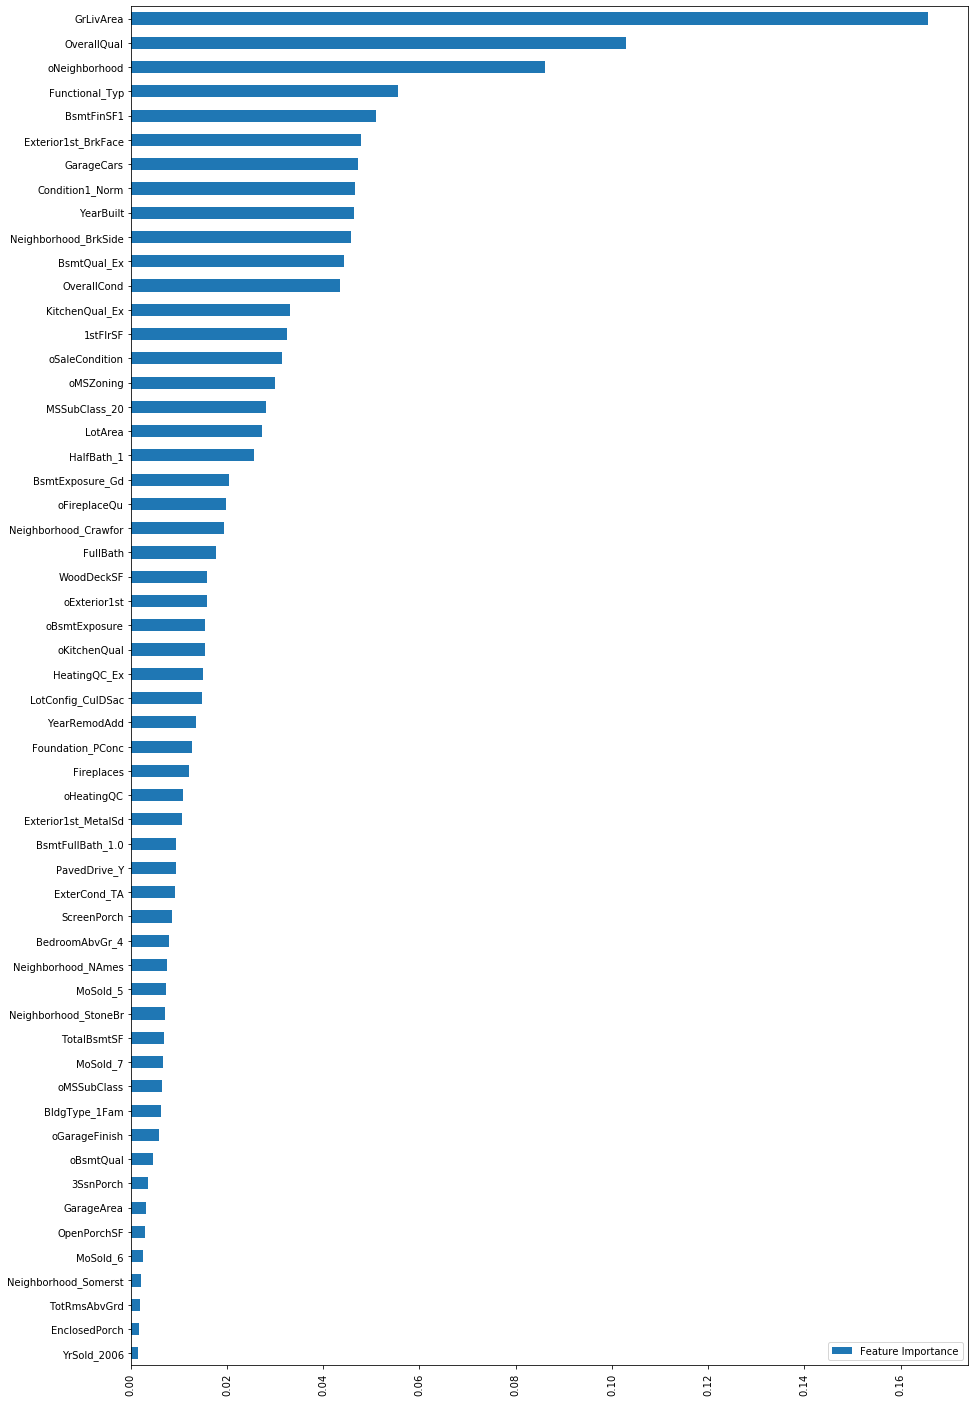

In [20]:
# 排序特徵重要程度
feature_importance_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=data_pipe.columns)
feature_importance_lasso.sort_values("Feature Importance", ascending=False)
feature_importance_lasso[feature_importance_lasso["Feature Importance"] > 0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

### 增加特徵 
有些欄位可以互相結合成為一個新的特徵

In [21]:
# 增加特徵
class add_feature(BaseEstimator, TransformerMixin):
    def __init__(self,additional=1):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
        X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]

        X["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
        X["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]
        X["+_oMSZoning_TotalHouse"] = X["oMSZoning"] * X["TotalHouse"]
        X["+_oMSZoning_OverallQual"] = X["oMSZoning"] + X["OverallQual"]
        X["+_oMSZoning_YearBuilt"] = X["oMSZoning"] + X["YearBuilt"]
        X["+_oNeighborhood_TotalHouse"] = X["oNeighborhood"] * X["TotalHouse"]
        X["+_oNeighborhood_OverallQual"] = X["oNeighborhood"] + X["OverallQual"]
        X["+_oNeighborhood_YearBuilt"] = X["oNeighborhood"] + X["YearBuilt"]
        X["+_BsmtFinSF1_OverallQual"] = X["BsmtFinSF1"] * X["OverallQual"]

        X["-_oFunctional_TotalHouse"] = X["oFunctional"] * X["TotalHouse"]
        X["-_oFunctional_OverallQual"] = X["oFunctional"] + X["OverallQual"]
        X["-_LotArea_OverallQual"] = X["LotArea"] * X["OverallQual"]
        X["-_TotalHouse_LotArea"] = X["TotalHouse"] + X["LotArea"]
        X["-_oCondition1_TotalHouse"] = X["oCondition1"] * X["TotalHouse"]
        X["-_oCondition1_OverallQual"] = X["oCondition1"] + X["OverallQual"]


        X["Bsmt"] = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
        X["Rooms"] = X["FullBath"]+X["TotRmsAbvGrd"]
        X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
        X["TotalPlace"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]


        return X

In [22]:
pipe = Pipeline([('label_encoding', label_encoding()), 
                 ('add_feature', add_feature()),
                 ('skew_transform', skew_transform(skew=0.75)), 
                 ('one_hot_encoding', one_hot_encoding())])

In [23]:
full_pipe = pipe.fit_transform(alldata)
print(full_pipe.shape)

(2919, 422)


In [24]:
n_train=train.shape[0]
X = full_pipe[:n_train]
test_X = full_pipe[n_train:]
y= train.SalePrice

X_scaled = scaler.fit(X).transform(X)
y_log = np.log(train.SalePrice)
test_X_scaled = scaler.transform(test_X)

In [25]:
pca = PCA(n_components=410)

In [26]:
X_scaled=pca.fit_transform(X_scaled)
test_X_scaled = pca.transform(test_X_scaled)
print(X_scaled.shape, test_X_scaled.shape)

(1460, 410) (1459, 410)


### 集成方法 (Ensemble Methods)

In [27]:
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod
        self.meta_model = meta_model
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)
        
    def fit(self,X,y):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))
        
        for i,model in enumerate(self.mod):
            for train_index, val_index in self.kf.split(X,y):
                renew_model = clone(model)
                renew_model.fit(X[train_index], y[train_index])
                self.saved_model[i].append(renew_model)
                oof_train[val_index,i] = renew_model.predict(X[val_index])
        
        self.meta_model.fit(oof_train,y)
        return self
    
    def predict(self,X):
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) 
                                      for single_model in self.saved_model]) 
        return self.meta_model.predict(whole_test)
    
    def get_oof(self,X,y,test_X):
        oof = np.zeros((X.shape[0],len(self.mod)))
        test_single = np.zeros((test_X.shape[0],5))
        test_mean = np.zeros((test_X.shape[0],len(self.mod)))
        for i,model in enumerate(self.mod):
            for j, (train_index,val_index) in enumerate(self.kf.split(X,y)):
                clone_model = clone(model)
                clone_model.fit(X[train_index],y[train_index])
                oof[val_index,i] = clone_model.predict(X[val_index])
                test_single[:,j] = clone_model.predict(test_X)
            test_mean[:,i] = test_single.mean(axis=1)
        return oof, test_mean

In [28]:
lasso = Lasso(alpha=0.0005,max_iter=10000)
ridge = Ridge(alpha=60)
svr = SVR(gamma= 0.0004,kernel='rbf',C=13,epsilon=0.009)
ker = KernelRidge(alpha=0.2 ,kernel='polynomial',degree=3 , coef0=0.8)
ela = ElasticNet(alpha=0.005,l1_ratio=0.08,max_iter=10000)
bay = BayesianRidge()
stack_model = stacking(mod=[lasso,ridge,svr,ker,ela,bay],meta_model=ker)

In [29]:
a = Imputer().fit_transform(X_scaled)
b = Imputer().fit_transform(y_log.values.reshape(-1,1)).ravel()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [30]:
stack_model.fit(a, b)

stacking(meta_model=KernelRidge(alpha=0.2, coef0=0.8, degree=3, gamma=None,
                                kernel='polynomial', kernel_params=None),
         mod=[Lasso(alpha=0.0005, copy_X=True, fit_intercept=True,
                    max_iter=10000, normalize=False, positive=False,
                    precompute=False, random_state=None, selection='cyclic',
                    tol=0.0001, warm_start=False),
              Ridge(alpha=60, copy_X=True, fit_intercept=True, max_iter...
              ElasticNet(alpha=0.005, copy_X=True, fit_intercept=True,
                         l1_ratio=0.08, max_iter=10000, normalize=False,
                         positive=False, precompute=False, random_state=None,
                         selection='cyclic', tol=0.0001, warm_start=False),
              BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False,
                            copy_X=True, fit_intercept=True, lambda_1=1e-06,
                            lambda_2=1e-06, n_iter=300, n

In [31]:
pred = np.exp(stack_model.predict(test_X_scaled))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support 

In [32]:
result=pd.DataFrame({'Id':test.Id, 'SalePrice':pred})
result.to_csv("submission.csv",index=False)